In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
!wget http://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat

URL transformed to HTTPS due to an HSTS policy
--2024-02-01 08:23:43--  https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat
Resolving spdf.gsfc.nasa.gov (spdf.gsfc.nasa.gov)... 169.154.154.63, 2001:4d0:2418:121::63
Connecting to spdf.gsfc.nasa.gov (spdf.gsfc.nasa.gov)|169.154.154.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178269312 (170M)
Saving to: ‘omni2_all_years.dat.1’

omni2_all_years.dat 100%[===================>] 170.01M   259MB/s    in 0.7s    

2024-02-01 08:23:44 (259 MB/s) - ‘omni2_all_years.dat.1’ saved [178269312/178269312]



In [25]:
with open("omni2_all_years.dat") as f:
    print(f.readline())

1963   1  0 1771 99 99 999 999 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 9999999. 999.9 9999. 999.9 999.9 9.999 99.99 9999999. 999.9 9999. 999.9 999.9 9.999 999.99 999.99 999.9  7  33    -6  119 999999.99 99999.99 99999.99 99999.99 99999.99 99999.99  0   3 999.9 999.9 99999 99999 99.9



In [26]:
df = pd.read_csv("omni2_all_years.dat",
                 delim_whitespace=True,
                 usecols=[0, 1, 2, 39, 40, 50],
                 names=["Year", "DOY", "Hour", "R", "Dst", "F10.7"])

In [27]:
df.head()

,Year,DOY,Hour,R,Dst,F10.7
0,1963,1,0,33,-6,999.9
1,1963,1,1,33,-5,999.9
2,1963,1,2,33,-5,999.9
3,1963,1,3,33,-3,999.9
4,1963,1,4,33,-3,999.9


In [28]:
df.index = pd.to_datetime(df["Year"] * 100000 + df["DOY"] * 100 + df["Hour"], format="%Y%j%H")
df = df.drop(columns=["Year", "DOY", "Hour"])

In [29]:
df.head()

,R,Dst,F10.7
1963-01-01 00:00:00,33,-6,999.9
1963-01-01 01:00:00,33,-5,999.9
1963-01-01 02:00:00,33,-5,999.9
1963-01-01 03:00:00,33,-3,999.9
1963-01-01 04:00:00,33,-3,999.9


In [30]:
df = df.replace({"R":999,
                 "Dst":99999,
                 "F10.7":999.9}, np.nan)
df.head()

,R,Dst,F10.7
1963-01-01 00:00:00,33.0,-6.0,NaN
1963-01-01 01:00:00,33.0,-5.0,NaN
1963-01-01 02:00:00,33.0,-5.0,NaN
1963-01-01 03:00:00,33.0,-3.0,NaN
1963-01-01 04:00:00,33.0,-3.0,NaN


In [31]:
print("Dataframe shape: ", df.shape)
dt = (df.index[-1] - df.index[0])
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

Dataframe shape:  (543504, 3)
Number of hours between start and end dates:  543504.0


In [32]:
  h, d, y = 24, 365, 55
print(f"{h} hours/day * {d} days/year * {y} years = {h*d*y} hours")

24 hours/day * 365 days/year * 55 years = 481800 hours


In [33]:
print("{} hours/day * {} days/year * {} years = {} hours".format(h, d , y, h*d*y))
print("%d hours/day * %d days/year * %d years = %d hours"%(h, d , y, h*d*y))

24 hours/day * 365 days/year * 55 years = 481800 hours
24 hours/day * 365 days/year * 55 years = 481800 hours


<Axes: xlabel='R'>

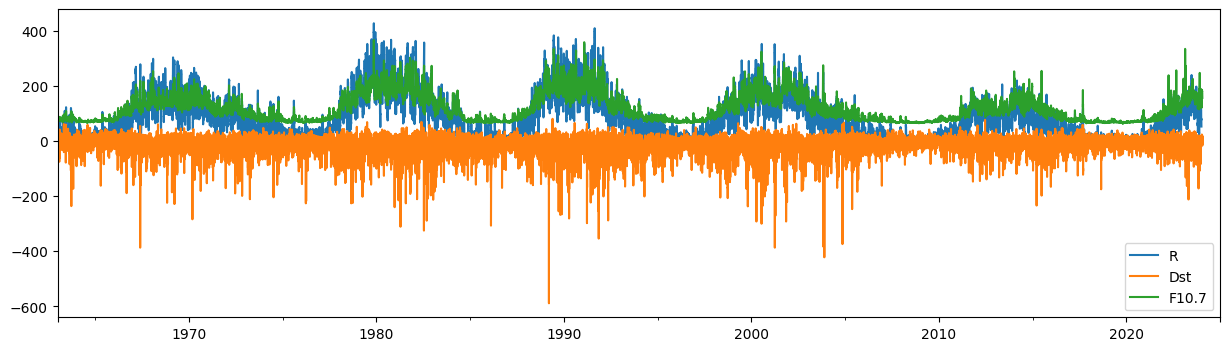

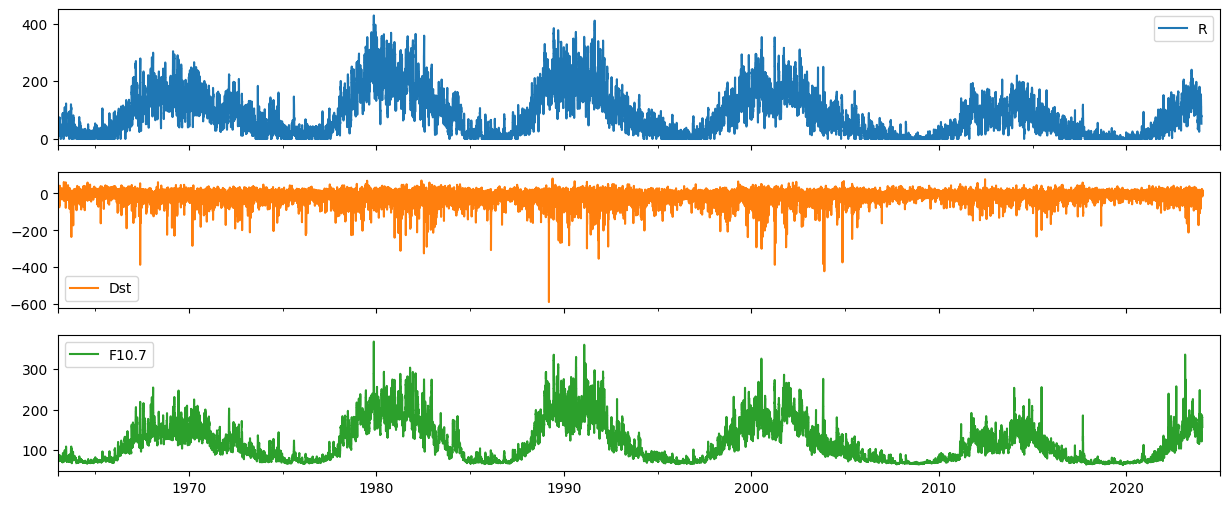

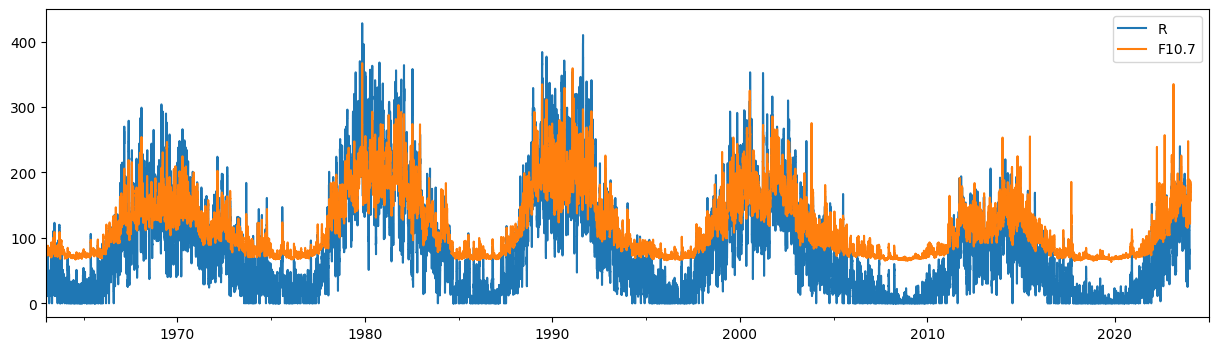

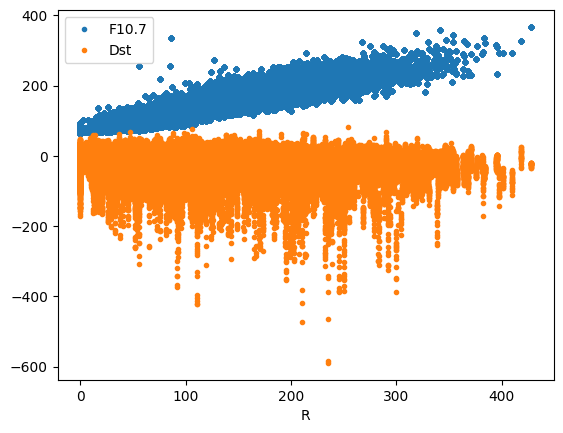

In [34]:
df.plot(figsize=(15,4))
df.plot(subplots=True, figsize=(15,6))
df.plot(y=["R", "F10.7"], figsize=(15,4))
df.plot(x="R", y=["F10.7", "Dst"], style='.')

<Axes: >

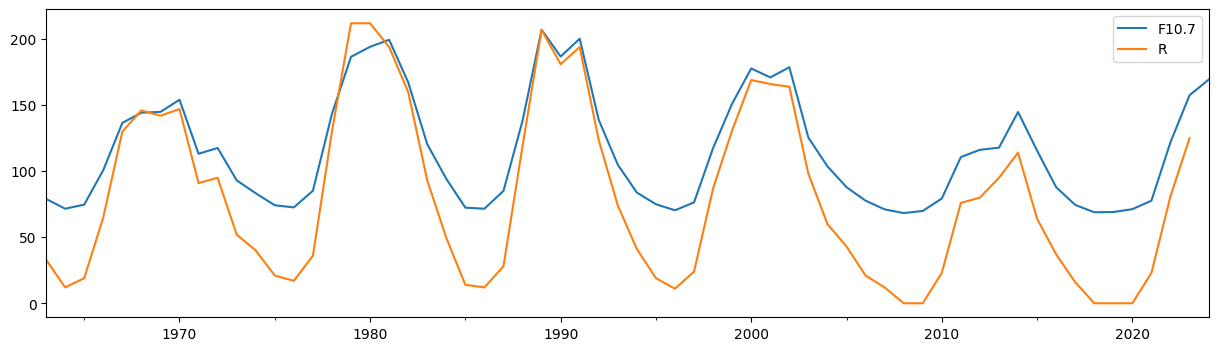

In [35]:
df[["F10.7", "R"]].resample("1y").median().plot(figsize=(15,4))

<Axes: >

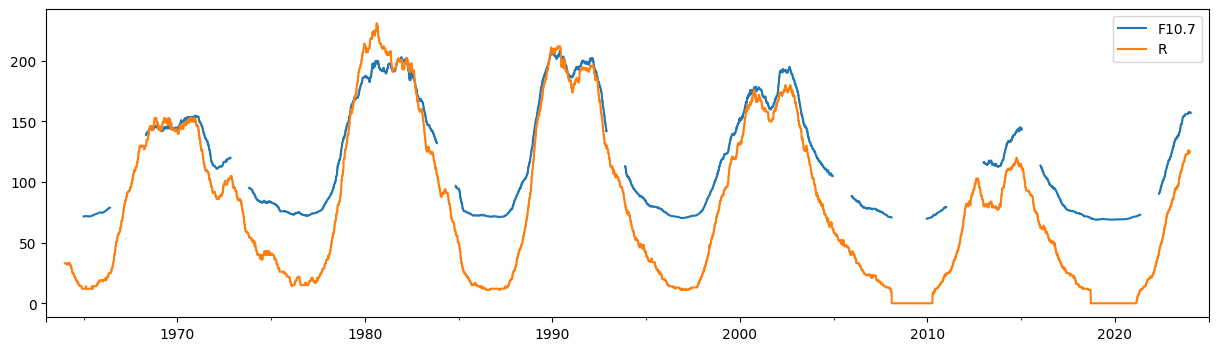

In [36]:
df[["F10.7", "R"]].rolling(24*365).median().plot(figsize=(15,4))

array([<Axes: >, <Axes: >], dtype=object)

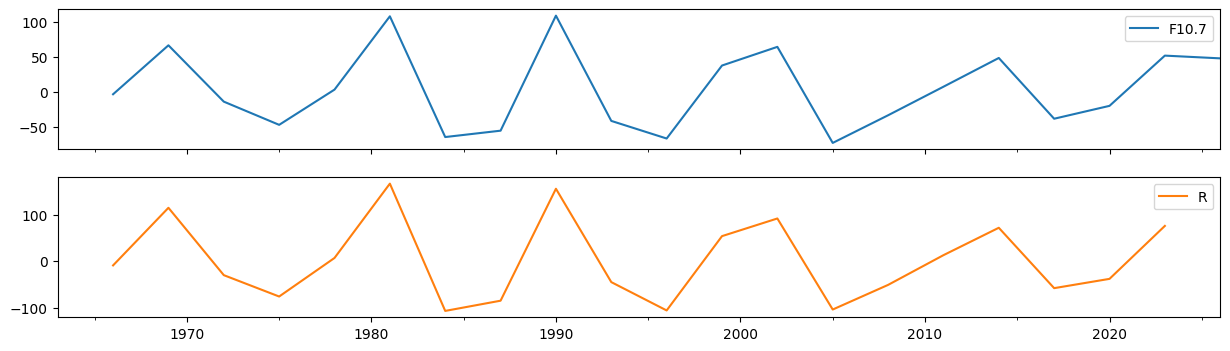

In [37]:
df[["F10.7", "R"]].resample("3y").median().diff().plot(subplots=True, figsize=(15,4))

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

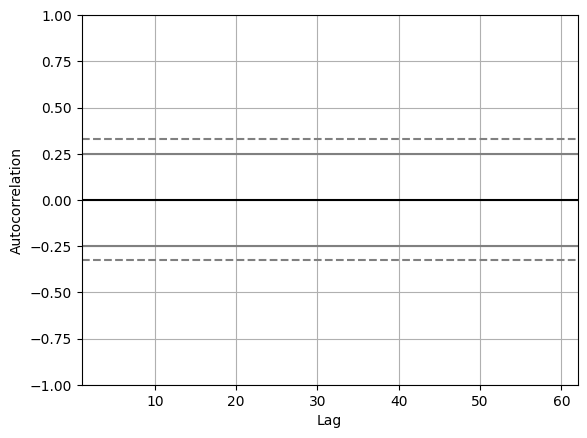

In [38]:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())

In [39]:
Dst_count = df["Dst"].where(df["Dst"]<-100).resample("1y").count()
Dst_count = Dst_count.reindex(df.index, method="bfill")

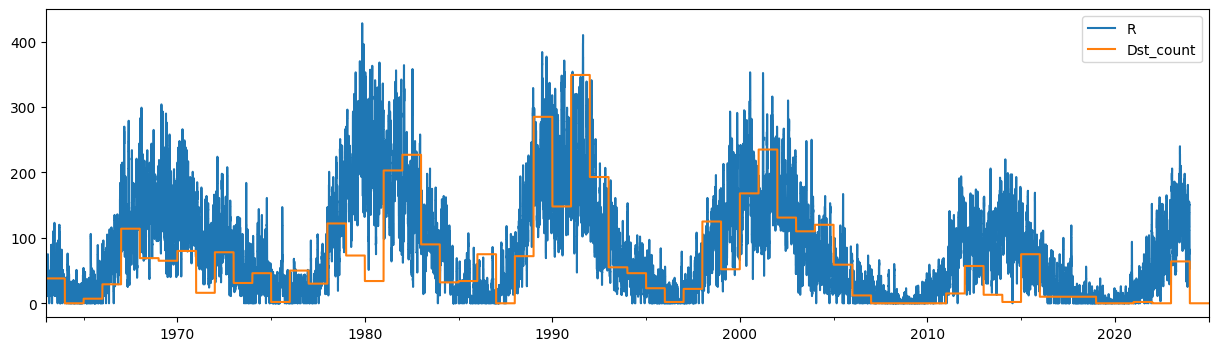

In [40]:
df["Dst_count"] = Dst_count
df.plot(y=["R", "Dst_count"], figsize=(15,4));

In [41]:
# https://en.wikipedia.org/wiki/List_of_solar_cycles
minima = ["1964-10", "1976-03", "1986-09", "1996-08", "2008-12", "2019-12"]
df_daily = df.resample("1D").mean()

def split_into_cycles(df):
    """Returns a list of dataframes, one for each solar cycle"""
    cycles = []
    # Split by solar cycle
    for start, end in zip(minima[0:-1], minima[1:]):
        cycle = df[start:end]
        # Convert from dates to days from minimum
        cycle.index = (cycle.index - cycle.index[0]).days
        # Extend so that each cycle lasts a full 5000 days (filled with nan)
        ix = pd.Int64Index(np.arange(0,5000))
        cycle.reindex(ix)
        cycles.append(cycle)
    return cycles

cycles = split_into_cycles(df_daily)

<ipython-input-41-fd227ba46741>:14: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ix = pd.Int64Index(np.arange(0,5000))
<ipython-input-41-fd227ba46741>:14: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ix = pd.Int64Index(np.arange(0,5000))
<ipython-input-41-fd227ba46741>:14: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ix = pd.Int64Index(np.arange(0,5000))
<ipython-input-41-fd227ba46741>:14: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ix = pd.Int64Index(np.arange(0,5000))
<ipython-input-41-fd227ba46741>:14: FutureWarning: pandas.Int64Index is deprecated a

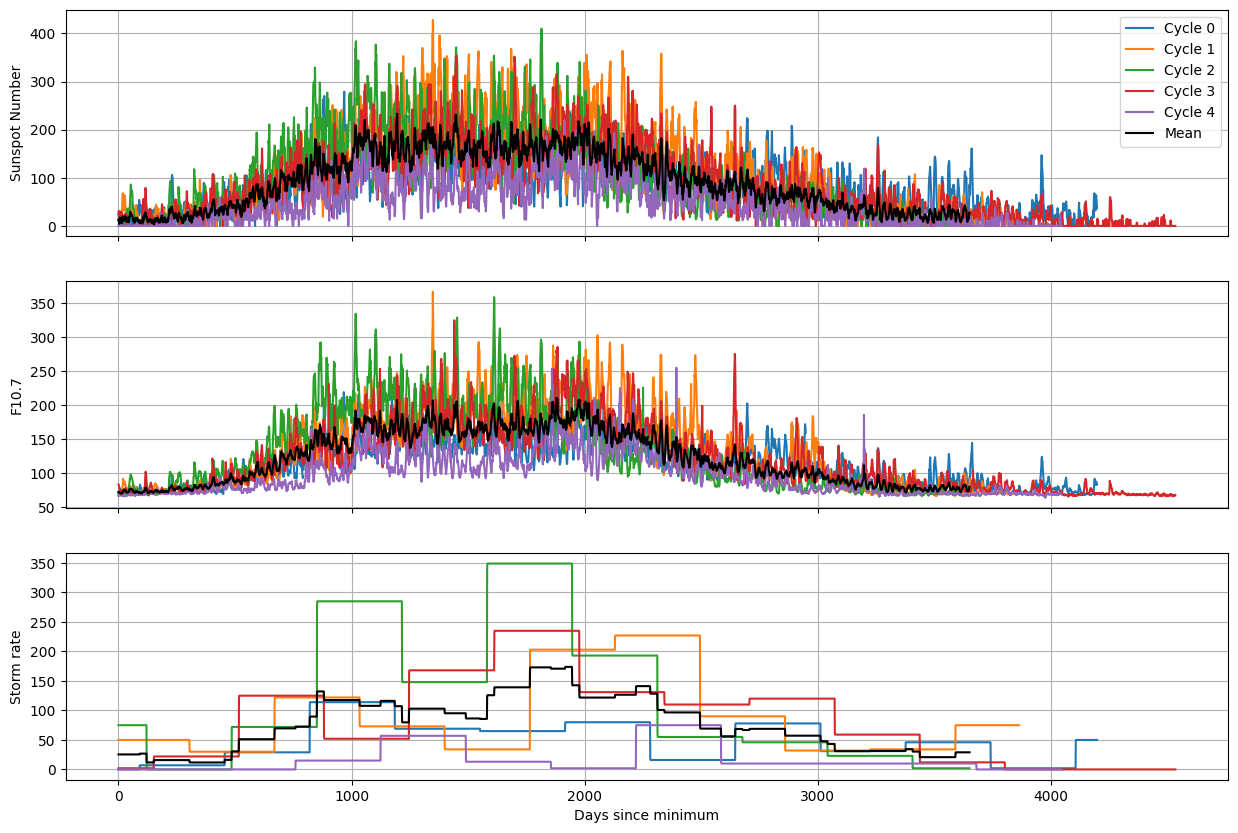

In [42]:
fig, axes = plt.subplots(3, 1, figsize=(15,10), sharex=True)
for i, cycle in enumerate(cycles):
    cycle["R"].plot(ax=axes[0], label=f"Cycle {i}")
    cycle["F10.7"].plot(ax=axes[1])
    cycle["Dst_count"].plot(ax=axes[2])
N_cycles = len(cycles)
(sum(cycles)["R"]/N_cycles).plot(ax=axes[0], color="black", label="Mean")
(sum(cycles)["F10.7"]/N_cycles).plot(ax=axes[1], color="black")
(sum(cycles)["Dst_count"]/N_cycles).plot(ax=axes[2], color="black")
axes[0].legend()
axes[0].set_ylabel("Sunspot Number")
axes[1].set_ylabel("F10.7")
axes[2].set_ylabel("Storm rate")
axes[2].set_xlabel("Days since minimum")
for ax in axes:
    ax.grid()